In [223]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [224]:
df = pd.read_csv("/Users/dominikorzel-walker/Downloads/AirPassengers.csv")

df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


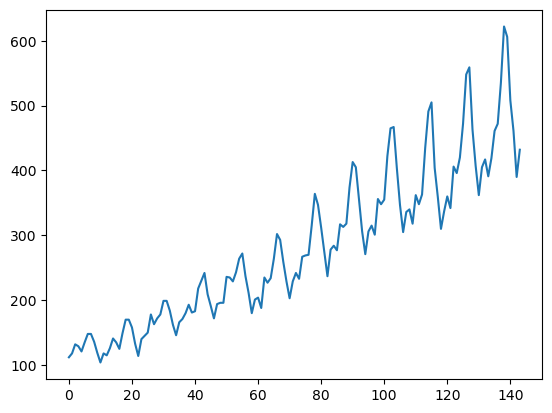

In [225]:
num_passengers = df["#Passengers"]

num_passengers.plot();

# ARIMA Model

We conduct an ADF test on the original dataset to see if the data is stationary

In [226]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [227]:
adf = adfuller(num_passengers)
print(f"p-value: {adf[1]}")

p-value: 0.9918802434376408


Since we have a very large $p$-value, we conclude that the data is not stationary and we will require differencing

In [228]:
diff_num_passengers = num_passengers.diff().dropna()

adf_diff = adfuller(diff_num_passengers)
print(f"p-value: {adf_diff[1]}")

p-value: 0.05421329028382792


After differencing once, the $p$-value reduces to around $0.05$, so we will try $d=1$ and see if this produces a strong prediction

We now plot ACF and PACF plots on the differenced data to see some viable values of $p$ and $q$

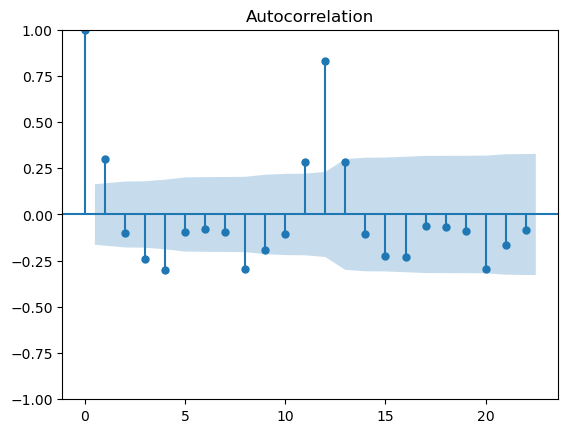

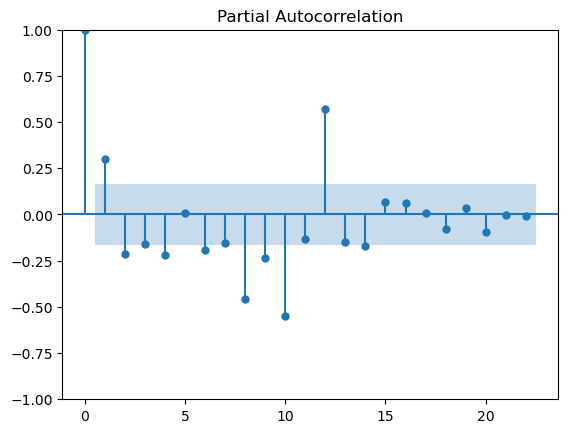

In [229]:
acf_diff = plot_acf(diff_num_passengers)

pacf_diff = plot_pacf(diff_num_passengers)

Values that lie outside of the acceptance band are generally the possible candidates, but we will import an algorithm that will find us the optimal $p$ and $q$ for this model

When training an ARIMA model, it is quite typical to use a larger-sized training set (thus a smaller testing set)

In [230]:
train = num_passengers[: int(0.9 * len(num_passengers))]

test = num_passengers[int(0.9 * len(num_passengers)) :]

In [231]:
model_autoARIMA = auto_arima(train, start_p = 0, start_q = 0, test = "adf", max_p = 7, max_q = 7, m = 1, d = 1, seasonal = False, start_P = 0, D = 0, trace = True, error_action = "ignore", suppress_warnings = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1243.851, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1236.997, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1233.059, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1242.868, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1224.958, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1228.456, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1232.384, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1190.435, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 A

So the algorithm tells us that a $(2,1,2)$ model is best for this problem. Already, this is a good model since the parameters $p,q$ are small so this will ensure we do not overfit to the training set. However, we do need to ensure we produce accurate predictions

We fit the model to the training data and print out the summary data

In [232]:
model = ARIMA(train, order = (2, 1, 2))

fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  129
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -592.714
Date:                Wed, 15 Jan 2025   AIC                           1195.429
Time:                        22:50:42   BIC                           1209.689
Sample:                             0   HQIC                          1201.223
                                - 129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6949      0.025     67.539      0.000       1.646       1.744
ar.L2         -0.9599      0.024    -39.723      0.000      -1.007      -0.913
ma.L1         -1.8368      0.063    -28.936      0.0

We now produce forecasted values to compare to the true outcome

In [233]:
forecast = fitted.forecast(len(test))

Plot the results to graphically see the accuracy

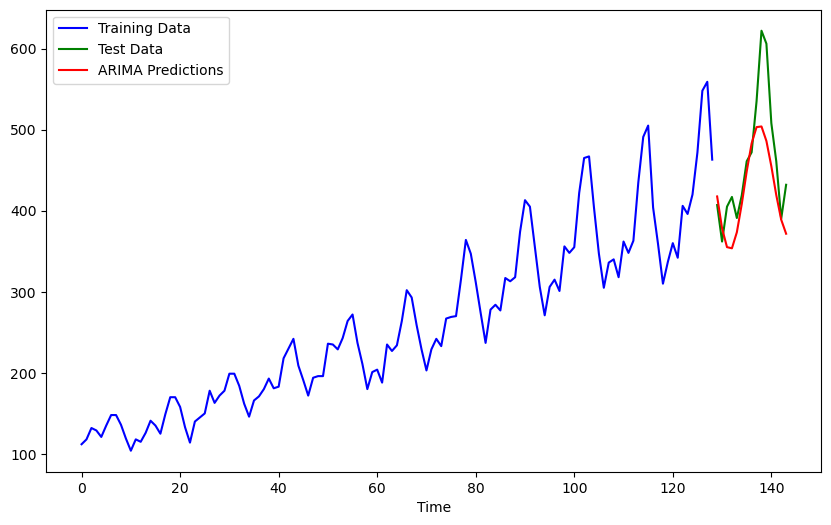

In [234]:
plt.figure(figsize = (10, 6))

plt.plot(train, label = "Training Data", color = "blue")
plt.plot(test, label = "Test Data", color = "green")
plt.plot(forecast, label = "ARIMA Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

The predictions are ok, not overfit to the data and pick up a general shape, but the peak is much too low

# Random Forest Regressor (No Feature Engineering)

Here, we apply a Random Forest Regressor to the dataset, only taking in the 'Month' column (which we decompose into individual 'Year' and 'Month of Year' columns) to predict

In [235]:
from sklearn.ensemble import RandomForestRegressor

In [236]:
df_RF = df.copy()

In [237]:
df_RF.Month = pd.to_datetime(df_RF.Month)

df_RF["Year"] = df_RF.Month.dt.year

df_RF["Month of Year"] = df_RF.Month.dt.month

df_RF.drop("Month", axis = 1, inplace = True)

df_RF.head(10)

,#Passengers,Year,Month of Year
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5
5,135,1949,6
6,148,1949,7
7,148,1949,8
8,136,1949,9
9,119,1949,10


Machine Learning models will generally be trained on smaller training sets, so we size down for these last two models. Whilst this doesn't allow for complete comparison between ARIMA and these, we can still compare from how well they are interpreting their respective data

In [238]:
X_train = df_RF.drop("#Passengers", axis = 1).iloc[: int(0.8 * len(df.index))]
X_test = df_RF.drop("#Passengers", axis = 1).iloc[int(0.8 * len(df.index)): ]

y_train = df_RF["#Passengers"].iloc[: int(0.8 * len(df.index))]
y_test = df_RF["#Passengers"].iloc[int(0.8 * len(df.index)): ]

In [239]:
rfr = RandomForestRegressor(random_state = 32)

rfr.fit(X_train, y_train);

In [240]:
y_predictions = rfr.predict(X_test)

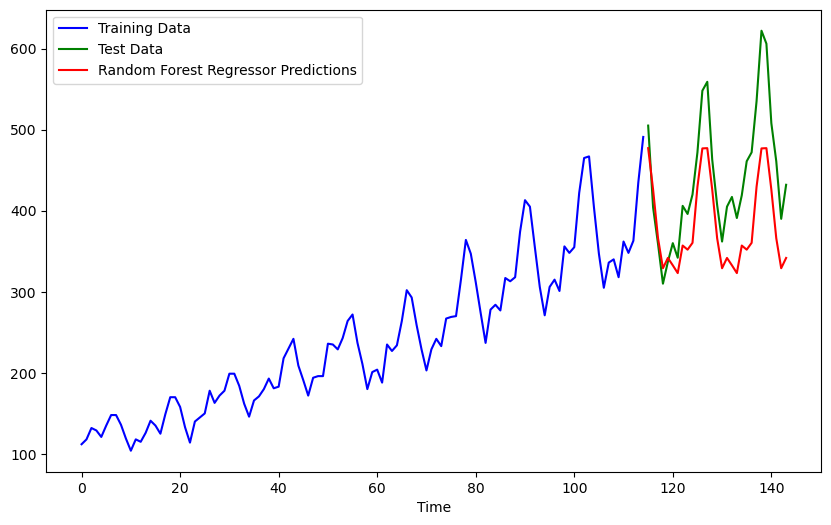

In [241]:
plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, label = "Training Data", color = "blue")
plt.plot(y_test.index, y_test, label = "Test Data", color = "green")
plt.plot(y_test.index, y_predictions, label = "Random Forest Regressor Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

So we see that whilst the random forest regressor does capture a trend, it doesn't pick up on the upward trending mean of the data and assumes it's 'sinusoidal'

# Random Forest Regressor (Feature Engineering)

Now we employ feature engineering to improve the accuracy of predictions. 

We introduce a '1 Month Lag', '3 Month Lag' and '3 Month EMA' (Expected Moving Average). This final feature puts weight on the most recent data to try and best capture its trends 

In [242]:
df_RF["1 Month Lag"] = df_RF["#Passengers"].shift(1)
df_RF["3 Month Lag"] = df_RF["#Passengers"].shift(3)

df_RF

,#Passengers,Year,Month of Year,1 Month Lag,3 Month Lag
0,112,1949,1,NaN,NaN
1,118,1949,2,112.0,NaN
2,132,1949,3,118.0,NaN
3,129,1949,4,132.0,112.0
4,121,1949,5,129.0,118.0
...,...,...,...,...,...
139,606,1960,8,622.0,472.0
140,508,1960,9,606.0,535.0
141,461,1960,10,508.0,622.0
142,390,1960,11,461.0,606.0


We need to fill in the missing values. By examining the data, we see that Jan and Dec numbers are generally about the same, so we use this to fill in the NaN in '1 Month Lag'. On further inspection, Nov seems on average around 20 units less than Oct and Oct is around the same value as in Dec. We use this to fill in the 3 NaNs in '3 Month Lag'

In [243]:
df_RF["1 Month Lag"][0] = df_RF["1 Month Lag"][1]

df_RF["3 Month Lag"][2] = df_RF["3 Month Lag"][3]
df_RF["3 Month Lag"][1] = df_RF["3 Month Lag"][2] - 20
df_RF["3 Month Lag"][0] = df_RF["3 Month Lag"][2]

In [244]:
df_RF["3 Month EMA"] = df_RF["#Passengers"].ewm(span = 3, adjust = False).mean()

In [245]:
X_train = df_RF.drop("#Passengers", axis = 1).iloc[: int(0.8 * len(df.index))]
X_test = df_RF.drop("#Passengers", axis = 1).iloc[int(0.8 * len(df.index)): ]

y_train = df_RF["#Passengers"].iloc[: int(0.8 * len(df.index))]
y_test = df_RF["#Passengers"].iloc[int(0.8 * len(df.index)): ]

In [246]:
rfr = RandomForestRegressor(random_state = 32)

rfr.fit(X_train, y_train);

In [247]:
y_predictions = rfr.predict(X_test)

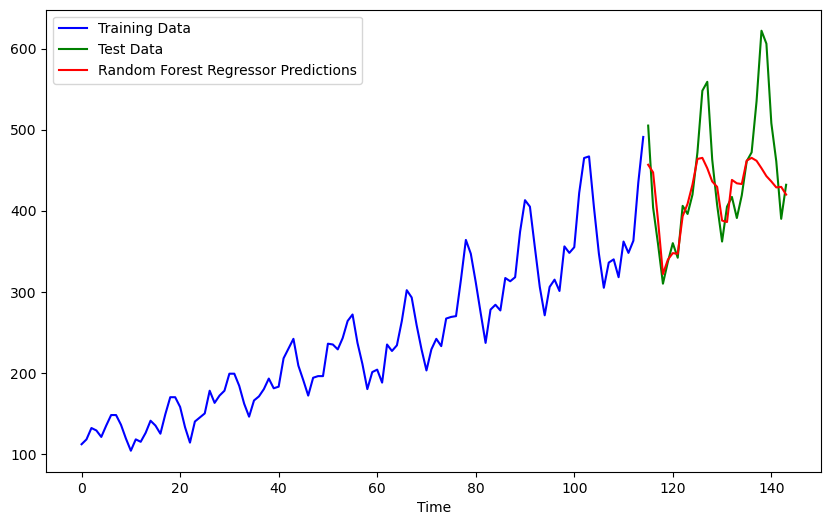

In [248]:
plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, label = "Training Data", color = "blue")
plt.plot(y_test.index, y_test, label = "Test Data", color = "green")
plt.plot(y_test.index, y_predictions, label = "Random Forest Regressor Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

We see that after introducing some new features, the Random Forest Regressor does notice the upward trend in the bottom of the data but still predicts it to be capped at the top, not fully capturing the increasing trend the data holds

# XGBoost Regressor (No Feature Engineering)

We do as we did for the Random Forest Regressor but instead use an XGBoost Regressor

In [249]:
from xgboost import XGBRegressor

In [250]:
df_XG = df.copy()

In [251]:
df_XG.Month = pd.to_datetime(df_XG.Month)

df_XG["Year"] = df_XG.Month.dt.year

df_XG["Month of Year"] = df_XG.Month.dt.month

df_XG.drop("Month", axis = 1, inplace = True)

In [252]:
X_train = df_XG.drop("#Passengers", axis = 1).iloc[: int(0.8 * len(df.index))]
X_test = df_XG.drop("#Passengers", axis = 1).iloc[int(0.8 * len(df.index)): ]

y_train = df_XG["#Passengers"].iloc[: int(0.8 * len(df.index))]
y_test = df_XG["#Passengers"].iloc[int(0.8 * len(df.index)): ]

In [253]:
xgbr = XGBRegressor()

xgbr.fit(X_train, y_train);

In [254]:
y_predictions = xgbr.predict(X_test)

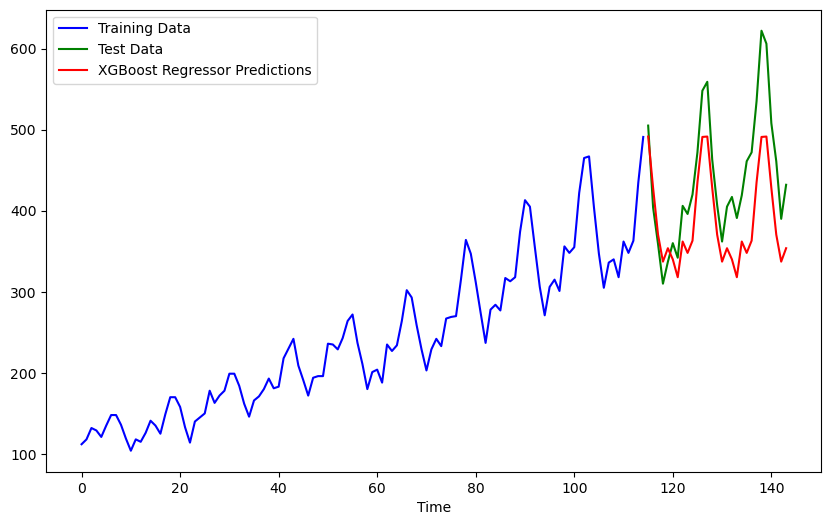

In [255]:
plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, label = "Training Data", color = "blue")
plt.plot(y_test.index, y_test, label = "Test Data", color = "green")
plt.plot(y_test.index, y_predictions, label = "XGBoost Regressor Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

XGBoost seems to be worse than Random Forest in this case

# XGBoost Regressor (Feature Engineering)

In [256]:
df_XG["1 Month Lag"] = df_XG["#Passengers"].shift(1)
df_XG["3 Month Lag"] = df_XG["#Passengers"].shift(3)


df_XG["1 Month Lag"][0] = df_XG["1 Month Lag"][1]

df_XG["3 Month Lag"][2] = df_XG["3 Month Lag"][3]
df_XG["3 Month Lag"][1] = df_XG["3 Month Lag"][2] - 20
df_XG["3 Month Lag"][0] = df_XG["3 Month Lag"][2]

In [257]:
df_XG["3 Month EMA"] = df_XG["#Passengers"].ewm(span = 3, adjust = False).mean()

In [258]:
X_train = df_XG.drop("#Passengers", axis = 1).iloc[: int(0.8 * len(df.index))]
X_test = df_XG.drop("#Passengers", axis = 1).iloc[int(0.8 * len(df.index)): ]

y_train = df_XG["#Passengers"].iloc[: int(0.8 * len(df.index))]
y_test = df_XG["#Passengers"].iloc[int(0.8 * len(df.index)): ]

In [259]:
xgbr = XGBRegressor()

xgbr.fit(X_train, y_train);

In [260]:
y_predictions = xgbr.predict(X_test)

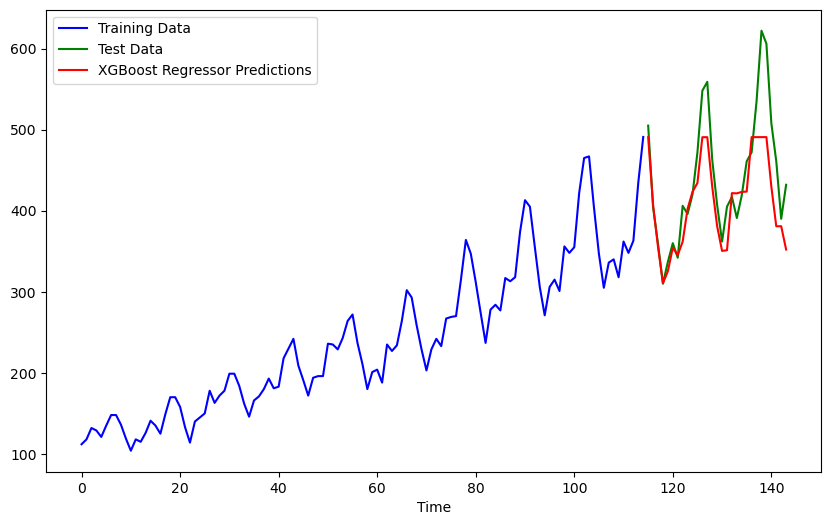

In [261]:

plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, label = "Training Data", color = "blue")
plt.plot(y_test.index, y_test, label = "Test Data", color = "green")
plt.plot(y_test.index, y_predictions, label = "XGBoost Regressor Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

We can see that XGBoost gives much more straight-lined predictions than Random Forest and that is due to the way in how these algorithms operate. 

XGBoost builds an ensemble of weak models (generally decision trees) in a sequential manner, where each tree is built to minimise a loss function, so only captures subtle adjustments. As a result, tree outputs can very often be straight lines.

Decision trees allows for trees to make deeper splits and so are able to better capture non-linear data, so as a result you find non-linear sections in the predictions.

### To conclude, we see that the machine learning predictions fit tighter to the data than the ARIMA predictions do, which we initially expect. However, in practice these methods are much more computationally expensive compared to ARIMA, and with further initial tuning on the dataset to make it more comfortable for the ARIMA, I believe that it could produce a strong output. As a result, I think that for a simple dataset like this, ARIMA is the way to go, but it will require some initial edits to the dataset, such as stabilising the variance and considering plots of the residuals.